# Full processing for moraine dam surface change
Quinn Brencher

In [1]:
# import packages
import os
import pyproj
pyproj.datadir.set_data_dir('/srv/conda/envs/mintpy/share/proj')
os.environ["PROJ_DATA"]="/srv/conda/envs/mintpy/share/proj"
from glob import glob
import geopandas as gpd
from pathlib import Path
from typing import List, Union
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
import rioxarray
import xarray as xr
import rasterio as rio
import datetime
from datetime import datetime, timedelta
import sys
from mintpy.utils import readfile, writefile, utils as ut, plot
from mintpy.cli import view, tsview, plot_network, plot_transection
from mintpy.view import prep_slice, plot_slice
import gc
import pandas as pd
import seaborn as sns
from scipy.stats import linregress
from rasterio.enums import Resampling
from matplotlib.colors import LogNorm

sns.set_theme()

In [2]:
# set up paths, directories, and variables for this specific dam
data_path = '/home/jovyan/repos/incubator_moraine_dam_analysis/data'
asc_burst = '012_023789_IW1'
des_burst = '121_258662_IW2'
asc_burst_path = f'{data_path}/data_igrams/{asc_burst}'
des_burst_path = f'{data_path}/data_igrams/{des_burst}'

dam_name = 'mera'
proc_path = f'/home/jovyan/repos/incubator_moraine_dam_analysis/dams/{dam_name}'

# define reference point, [y, x]
# reference_point = [3073675.4, 495086.2]

# define crs 
crs = 32645

In [15]:
# read in dam polygon
dam_fn = f'../../mapping/polygons/{dam_name}_md.shp'
dam_gdf = gpd.read_file(dam_fn)
dam_gdf = dam_gdf.to_crs(crs) # reproject in case of mistake

# load in moving area polygon
moving_fn = f'../../mapping/polygons/{dam_name}_moving.shp'
moving_gdf = gpd.read_file(moving_fn)

# load in reference area polygon
reference_fn = f'../../mapping/polygons/{dam_name}_reference.shp'
reference_gdf = gpd.read_file(reference_fn)

# load in stable area polygon
stable_fn = f'../../mapping/polygons/{dam_name}_stable.shp'
stable_gdf = gpd.read_file(stable_fn).to_crs(crs)

# load in water mask
water_fn = f'../../mapping/polygons/water_mask.shp'
water_gdf = gpd.read_file(water_fn).to_crs(crs)

# pad dam bounds by 5 km 
padding = 5000
aoi_extent = [dam_gdf.bounds.minx.item()-padding,
               dam_gdf.bounds.maxy.item()+padding,
               dam_gdf.bounds.maxx.item()+padding,
               dam_gdf.bounds.miny.item()-padding]

## crop InSAR data

In [4]:
def clip_hyp3_products_to_common_overlap(data_path: Union[str, Path], overlap: List[float]) -> None:    
    files_for_mintpy = ['_rng_off.tif', '_snr.tif', '_conncomp.tif', '_corr.tif', '_unw_phase.tif', '_dem.tif', '_lv_theta.tif', '_lv_phi.tif']
    for extension in files_for_mintpy:
        print(f'working on {extension}') 
        for file in data_path.rglob(f'*{extension}'):
            dst_file = file.parent / f'{file.stem}_{dam_name}{file.suffix}'
            if not os.path.isfile(dst_file):
                gdal.Translate(destName=str(dst_file), srcDS=str(file), projWin=overlap)

In [5]:
# # clip igram products to dam aoi
# clip_hyp3_products_to_common_overlap(Path(asc_burst_path), aoi_extent)
clip_hyp3_products_to_common_overlap(Path(des_burst_path), aoi_extent)

working on _rng_off.tif
working on _snr.tif
working on _conncomp.tif


/srv/conda/envs/mintpy/lib/python3.11/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


working on _corr.tif
working on _unw_phase.tif
working on _dem.tif
working on _lv_theta.tif
working on _lv_phi.tif


# load coherence time series

In [4]:
# functions to load interferogram tifs to xarray
def parse_file(file_path):
    data = {}
    with open(file_path, 'r') as file:
        for line in file:
            key, value = line.strip().split(': ')
            data[key] = value
    return data

def xr_read_geotif(geotif_file_path, masked=True):
    """
    Reads in single or multi-band GeoTIFF as dask array.
    Inputs
    ----------
    GeoTIFF_file_path : GeoTIFF file path
    Returns
    -------
    ds : xarray.Dataset
        Includes rioxarray extension to xarray.Dataset
    """

    da = rioxarray.open_rasterio(geotif_file_path, masked=True)

    # Extract bands and assign as variables in xr.Dataset()
    ds = xr.Dataset()
    for i, v in enumerate(da.band):
        da_tmp = da.sel(band=v)
        da_tmp.name = "band" + str(i + 1)

        ds[da_tmp.name] = da_tmp

    # Delete empty band coordinates.
    # Need to preserve spatial_ref coordinate, even though it appears empty.
    # See spatial_ref attributes under ds.coords.variables used by rioxarray extension.
    del ds.coords["band"]

    # Preserve top-level attributes and extract single value from value iterables e.g. (1,) --> 1
    ds.attrs = da.attrs
    for key, value in ds.attrs.items():
        try:
            if len(value) == 1:
                ds.attrs[key] = value[0]
        except TypeError:
            pass

    return ds

def hyp3_to_xarray(hyp3_dir, epsg, file_type='corr', interpolate_na=False):
    
    dirs = os.listdir(hyp3_dir) #list generated interferograms
    datasets = []
    acquisition_list = []
    
    for idir in dirs:
        tif_path = glob(f'{hyp3_dir}/{idir}/*/*{file_type}.tif')[0]
        tif_fn = os.path.split(tif_path)[-1]
        dates = f'{tif_fn[14:22]}_{tif_fn[23:31]}' #parse filename for interferogram dates
        start_date = datetime.strptime(dates[:8], '%Y%m%d')
        end_date = datetime.strptime(dates[-8:], '%Y%m%d')
        t_baseline = end_date - start_date
        middle_date = t_baseline/2+start_date
        
        src = xr_read_geotif(tif_path, masked=False) #read product to xarray ds
        src = src.assign_coords({"dates": dates})
        src = src.expand_dims("dates")
        
        src = src.assign_coords(start_date = ('dates', [start_date]))
        src = src.assign_coords(end_date = ('dates', [end_date]))
        src = src.assign_coords(t_baseline = ('dates', [t_baseline]))
        src = src.assign_coords(middle_date = ('dates', [middle_date]))
        
        src = src.rename({'band1':file_type})
        src = src.rio.write_crs(epsg)

        # # open metadata file
        # txt_path = glob(f'{hyp3_dir}/{idir}/*/*FFTS.txt')[0]
        # meta_dict = parse_file(txt_path)
        # src = src.assign_coords(perp_baseline = ('dates', [meta_dict['Baseline']]))
        
        if interpolate_na == True:
            src = src.interpolate_na(dim='x', method='linear').fillna(value=0)
        
        datasets.append(src)
        #print(src[file_type].shape, src.dates.item())
       
    ds = xr.concat(datasets, dim="dates", combine_attrs="no_conflicts") #create dataset
    ds = ds.sortby('dates')

    return ds 

In [5]:
asc_corr_ds = hyp3_to_xarray(asc_burst_path, crs, file_type=f'corr_{dam_name}')
des_corr_ds = hyp3_to_xarray(des_burst_path, crs, file_type=f'corr_{dam_name}')

In [31]:
asc_corr_ds = asc_corr_ds.where(asc_corr_ds.t_baseline.dt.days < 200, drop=True)

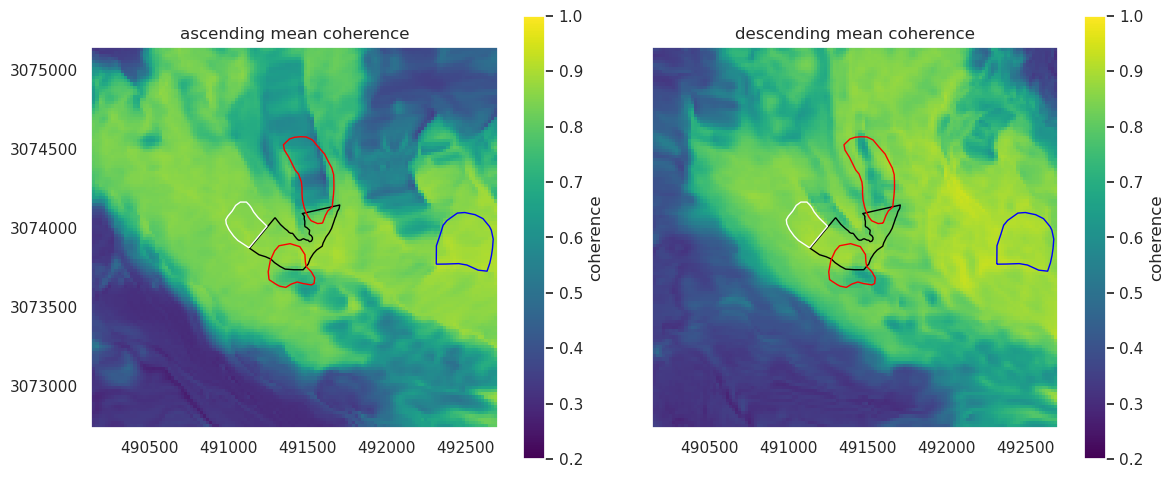

In [16]:
# plot mean spatial coherence
padding = 4000

f, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
asc_corr_ds[f'corr_{dam_name}'].mean(dim='dates').plot(ax=ax[0], vmin=0.2, vmax=1, cbar_kwargs= {'label':'coherence'})
dam_gdf.plot(ax=ax[0], edgecolor='black', facecolor='none')
moving_gdf.plot(ax=ax[0], edgecolor='red', facecolor='none')
stable_gdf.plot(ax=ax[0], edgecolor='blue', facecolor='none')
reference_gdf.plot(ax=ax[0], edgecolor='white', facecolor='none')
ax[0].set_title('ascending mean coherence')
# ax[0].scatter(reference_point[1], reference_point[0], c='k', s=5)
ax[0].set_aspect('equal')
ax[0].set_xlim(aoi_extent[0]+padding, aoi_extent[2]-padding)
ax[0].set_ylim(aoi_extent[3]+padding, aoi_extent[1]-padding)
ax[0].set_xlabel('')
ax[0].set_ylabel('')

des_corr_ds[f'corr_{dam_name}'].mean(dim='dates').plot(ax=ax[1], vmin=0.2, vmax=1, cbar_kwargs= {'label':'coherence'})
dam_gdf.plot(ax=ax[1], edgecolor='black', facecolor='none')
moving_gdf.plot(ax=ax[1], edgecolor='red', facecolor='none')
stable_gdf.plot(ax=ax[1], edgecolor='blue', facecolor='none')
reference_gdf.plot(ax=ax[1], edgecolor='white', facecolor='none')
# ax[1].scatter(reference_point[1], reference_point[0], c='k', s=5)
ax[1].set_title('descending mean coherence')
ax[1].set_aspect('equal')
ax[1].set_xlim(aoi_extent[0]+padding, aoi_extent[2]-padding)
ax[1].set_ylim(aoi_extent[3]+padding, aoi_extent[1]-padding)
f.tight_layout()
ax[1].set_xlabel('')
ax[1].set_ylabel('')

plt.savefig(f'./figs/{dam_name}_coherence_map.png', dpi=300)

In [9]:
# save coherence maps
asc_corr_ds[f'corr_{dam_name}'].mean(dim='dates').rio.to_raster(f'{dam_name}_asc_mean_coherence.tif')
des_corr_ds[f'corr_{dam_name}'].mean(dim='dates').rio.to_raster(f'{dam_name}_des_mean_coherence.tif')
combined_corr = (asc_corr_ds[f'corr_{dam_name}'].mean(dim='dates') + des_corr_ds[f'corr_{dam_name}'].mean(dim='dates'))/2
combined_corr.rio.to_raster(f'{dam_name}_combined_mean_coherence.tif')

In [17]:
# # clip datasets to dam polygon
# asc_dam_corr_ds = asc_corr_ds.rio.clip(dam_gdf.geometry.values, crs=dam_gdf.crs, drop=True)
# des_dam_corr_ds = des_corr_ds.rio.clip(dam_gdf.geometry.values, crs=dam_gdf.crs, drop=True)

# clip datasets to moving polygon
asc_dam_corr_ds = asc_corr_ds.rio.clip(moving_gdf.geometry.values, crs=moving_gdf.crs, drop=True)
des_dam_corr_ds = des_corr_ds.rio.clip(moving_gdf.geometry.values, crs=moving_gdf.crs, drop=True)

# clip datasets to stable polygon
asc_stable_corr_ds = asc_corr_ds.rio.clip(stable_gdf.geometry.values, crs=stable_gdf.crs, drop=True)
des_stable_corr_ds = des_corr_ds.rio.clip(stable_gdf.geometry.values, crs=stable_gdf.crs, drop=True)

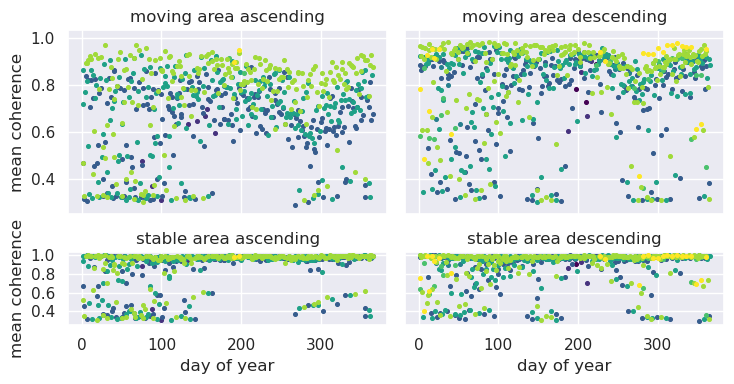

In [18]:
t_baselines = np.union1d(des_dam_corr_ds.t_baseline.dt.days.values, asc_dam_corr_ds.t_baseline.dt.days.values)

# plot seasonal changes in coherence 
colors = plt.cm.viridis(np.linspace(0, 1, len(t_baselines)))

f, ax = plt.subplots(2, 2, figsize=(7.5, 4), sharex=True, sharey=True, gridspec_kw={'height_ratios': [2.5, 1]})

# ax[0, 0].fill_betweenx([0.3, 1], 152, 334, color='grey', alpha=0.1)
# ax[0, 1].fill_betweenx([0.3, 1], 152, 334, color='grey', alpha=0.1)
# ax[1, 0].fill_betweenx([0.3, 1], 152, 334, color='grey', alpha=0.1)
# ax[1, 1].fill_betweenx([0.3, 1], 152, 334, color='grey', alpha=0.1)

for i, days in enumerate(reversed(t_baselines)):

    ax[0, 0].scatter(asc_dam_corr_ds.middle_date[asc_dam_corr_ds.t_baseline.dt.days == days].dt.dayofyear,
                  asc_dam_corr_ds[f'corr_{dam_name}'].mean(dim=['x', 'y'])[asc_dam_corr_ds.t_baseline.dt.days == days],
                  color=colors[i],
                  s=7,
                  label=f'{int(days)} days')
    ax[0, 0].tick_params(left=False)

    ax[0, 1].scatter(des_dam_corr_ds.middle_date[des_dam_corr_ds.t_baseline.dt.days == days].dt.dayofyear,
                  des_dam_corr_ds[f'corr_{dam_name}'].mean(dim=['x', 'y'])[des_dam_corr_ds.t_baseline.dt.days == days],
                  color=colors[i],
                  s=7,
                  label=f'{int(days)} days')
    ax[0, 1].tick_params(left=False)

    ax[1, 0].scatter(asc_stable_corr_ds.middle_date[asc_stable_corr_ds.t_baseline.dt.days == days].dt.dayofyear,
                  asc_stable_corr_ds[f'corr_{dam_name}'].mean(dim=['x', 'y'])[asc_stable_corr_ds.t_baseline.dt.days == days],
                  color=colors[i],
                  s=7,
                  label=f'{int(days)} days')

    ax[1, 1].scatter(des_stable_corr_ds.middle_date[des_stable_corr_ds.t_baseline.dt.days == days].dt.dayofyear,
                  des_stable_corr_ds[f'corr_{dam_name}'].mean(dim=['x', 'y'])[des_stable_corr_ds.t_baseline.dt.days == days],
                  color=colors[i],
                  s=7,
                  label=f'{int(days)} days')

    ax[0, 0].set_ylabel('mean coherence')
    ax[1, 0].set_ylabel('mean coherence')
    ax[1, 0].set_xlabel('day of year')
    ax[1, 1].set_xlabel('day of year')
    ax[0, 0].set_title('moving area ascending')
    ax[0, 1].set_title('moving area descending')
    ax[1, 0].set_title('stable area ascending')
    ax[1, 1].set_title('stable area descending')
    #ax[1, 1].legend(loc='lower right', fontsize=10, ncol=2)

    
f.tight_layout()
plt.savefig(f'./figs/{dam_name}_coherence_ts.png', dpi=300)

In [14]:
# calculate seasonal coherence change
asc_corr_ds_12day = asc_corr_ds.where(asc_corr_ds.t_baseline.dt.days == 12 , drop=True)
des_corr_ds_12day = des_corr_ds.where(des_corr_ds.t_baseline.dt.days == 12 , drop=True)

# low coherence period 
asc_lowcorr_ds = asc_corr_ds_12day.where((asc_corr_ds_12day.start_date.dt.dayofyear > 230) & (asc_corr_ds_12day.end_date.dt.dayofyear < 290), drop=True)
des_lowcorr_ds = des_corr_ds_12day.where((des_corr_ds_12day.start_date.dt.dayofyear > 230) & (des_corr_ds_12day.end_date.dt.dayofyear < 290), drop=True)

# high coherence period
asc_highcorr_ds = asc_corr_ds_12day.where((asc_corr_ds_12day.start_date.dt.dayofyear > 120) & (asc_corr_ds_12day.end_date.dt.dayofyear < 180), drop=True)
des_highcorr_ds = des_corr_ds_12day.where((des_corr_ds_12day.start_date.dt.dayofyear > 120) & (des_corr_ds_12day.end_date.dt.dayofyear < 180), drop=True)

# combined coherence
asc_lowcorr_da = asc_lowcorr_ds.median(dim='dates')[f'corr_{dam_name}']
des_lowcorr_da = des_lowcorr_ds.median(dim='dates')[f'corr_{dam_name}']
lowcorr_da = (asc_lowcorr_da + des_lowcorr_da)/2

asc_highcorr_da = asc_highcorr_ds.median(dim='dates')[f'corr_{dam_name}']
des_highcorr_da = des_highcorr_ds.median(dim='dates')[f'corr_{dam_name}']
highcorr_da = (asc_highcorr_da + des_highcorr_da)/2

# save seasonal coherence change
corr_change_da = (highcorr_da - lowcorr_da)
corr_change_da.rio.to_raster(f'{dam_name}_seasonal_coherence_change.tif')
ice_da = xr.where(corr_change_da >= 0.03, 1, 0).astype('float32')
ice_da.rio.to_raster(f'{dam_name}_ice_map.tif')

In [ ]:
# interpret plot
# if offsets will be needed to bridge summer gap, set use_offsets = True
use_offsets = True

In [ ]:
asc_acquisitions = xr.DataArray(np.union1d(asc_corr_ds.start_date, asc_corr_ds.end_date))
des_acquisitions = xr.DataArray(np.union1d(des_corr_ds.start_date, des_corr_ds.end_date))

## prepare offsets for processing

In [ ]:
# asc_burst_offsets_path = f'{data_path}/data_offsets/{asc_burst}'
# des_burst_offsets_path = f'{data_path}/data_offsets/{des_burst}'

In [ ]:
# # open offsets and SNR
# asc_offset_ds = hyp3_to_xarray(asc_burst_offsets_path, file_type=f'rng_off_{dam_name}')
# asc_snr_ds = hyp3_to_xarray(asc_burst_offsets_path, file_type=f'snr_{dam_name}')
# des_offset_ds = hyp3_to_xarray(des_burst_offsets_path, file_type=f'rng_off_{dam_name}')
# des_snr_ds = hyp3_to_xarray(des_burst_offsets_path, file_type=f'snr_{dam_name}')